c:\Users\bento\gis582\project\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


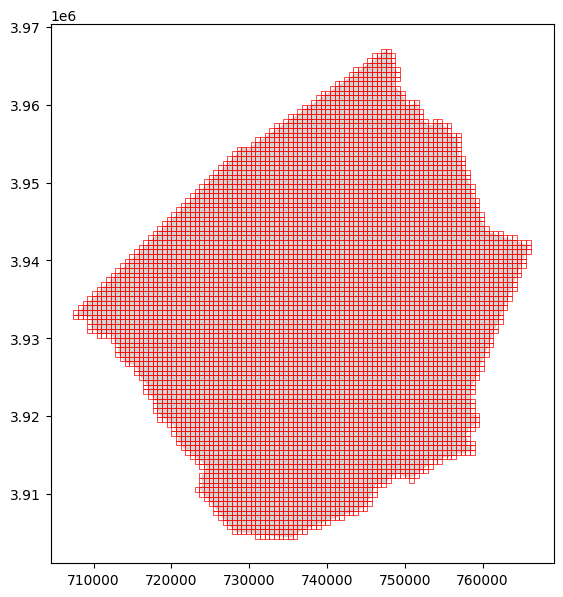

In [1]:
import os
import sys

sys.path.append("../model")
sys.path.append("..")

import math
import geopandas as gpd
import numpy as np
import pystac_client
import planetary_computer
import rioxarray
import xarray as xr
import rasterio
import rasterio.plot
import rasterio.warp
from rasterio.enums import Resampling
from rasterio.merge import merge
from rasterio.windows import from_bounds
# import stackstac
from shapely.geometry import box, mapping
from datetime import datetime
import torch
import yaml
from box import Box
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn import decomposition
from torchvision.transforms import v2
from src.model import ClayMAEModule

# Define your data directory and tile size
tiles_data_dir = "../data/tiles_gdb"
if not os.path.exists(tiles_data_dir):
    os.mkdir(tiles_data_dir)

tiles_geojson_path = "../data/tiles.geojson"
tile_size = 600  # Tile size in meters

county_boundary = gpd.read_file("../data/county_boundary.shp")
# Reproject to EPSG:32617 (UTM Zone 17N), which is the CRS used by 
# Sentinel-2 images in this region
if county_boundary.crs != 32617:
    county_boundary = county_boundary.to_crs("EPSG:32617")
    county_boundary.to_file("../data/county_boundary.shp")

minx, miny, maxx, maxy = county_boundary.total_bounds

# Adjust the bounds so that they align with the tile size
# For minx and miny, floor to the nearest multiple of tile_size
minx = math.floor(minx / tile_size) * tile_size
miny = math.floor(miny / tile_size) * tile_size
# For maxx and maxy, ceil to the nearest multiple of tile_size
maxx = math.ceil(maxx / tile_size) * tile_size
maxy = math.ceil(maxy / tile_size) * tile_size

# Generate tiles (i.e., bounding boxes in the format of xmin, ymin, xmax, ymax) 
# to fill the county boundary. If it overlaps the edge, extend outside (rather 
# than coming up short within the boundary), to ensure full coverage
# Get the bounds of the county boundary

if not os.path.exists(tiles_geojson_path):
    # Generate the grid of tiles
    all_tiles = []
    x_coords = np.arange(minx, maxx, tile_size)
    y_coords = np.arange(miny, maxy, tile_size)

    for x in x_coords:
        for y in y_coords:
            # Create a box for each tile
            tile = box(x, y, x + tile_size, y + tile_size)
            all_tiles.append(tile)
    # Create a GeoDataFrame for the tiles
    tiles_gdf = gpd.GeoDataFrame({'geometry': all_tiles}, crs=county_boundary.crs)
    # Keep only tiles that intersect the county, but keep their full geometry
    tiles_gdf = tiles_gdf[tiles_gdf.geometry.intersects(county_boundary.union_all())]\
        .reset_index(drop=True)
    # Remove duplicate tiles
    tiles_gdf = tiles_gdf.drop_duplicates()
    # Add columns for tracking satellite data
    tiles_gdf['processed'] = False
    tiles_gdf['data_files'] = [[] for _ in range(len(tiles_gdf))]
    # Save tiles_gdf to GeoJSON
    tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')
else:
    tiles_gdf = gpd.read_file(tiles_geojson_path)

# Generate raster and shapefile masks that match the external 
# bounds (and crs) of all of the tiles since it will not perfectly align with 
# the original boundary


# Create a unified boundary from all the tiles
tiles_union = tiles_gdf.union_all()

# Save the unified tiles boundary as a shapefile mask
tiles_union_gdf = gpd.GeoDataFrame(geometry=[tiles_union], crs=tiles_gdf.crs)
tiles_union_shapefile_path = "../data/tiles_union_mask.shp"
tiles_union_gdf.to_file(tiles_union_shapefile_path)

# Create a raster mask matching the external bounds and CRS of all tiles
# Define the raster properties
minx_tiles, miny_tiles, maxx_tiles, maxy_tiles = tiles_union.bounds
pixel_size = 10  # Pixel size in meters (adjust as needed)

# Calculate the number of rows and columns
ncols = int((maxx_tiles - minx_tiles) / pixel_size)
nrows = int((maxy_tiles - miny_tiles) / pixel_size)

# Define the transform for the raster
transform = rasterio.transform.from_origin(minx_tiles, maxy_tiles, 
                                           pixel_size, pixel_size)

# Define the raster metadata
raster_meta = {
    'driver': 'GTiff',
    'height': nrows,
    'width': ncols,
    'count': 1,
    'dtype': 'uint8',
    'crs': tiles_gdf.crs,
    'transform': transform
}

# Path to save the raster mask
raster_mask_path = "../data/tiles_union_mask.tif"

# Create the raster mask
with rasterio.open(raster_mask_path, 'w', **raster_meta) as out_raster:
    # Burn the unified tiles geometry into the raster
    shapes = [(tiles_union, 1)]
    burned = rasterio.features.rasterize(
        shapes,
        out_shape=(nrows, ncols),
        transform=transform,
        fill=0,
        all_touched=True,
        dtype='uint8'
    )
    out_raster.write_band(1, burned)

# Visualize the tiles and vectors (optional)
ax = county_boundary.plot(color='lightgray', figsize=(7, 7))
tiles_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=0.5)
plt.show()

In [2]:
# Calculate the width and height of each tile
tiles_gdf['width'] = tiles_gdf.geometry.bounds.apply(lambda row: row.maxx - row.minx, axis=1)
tiles_gdf['height'] = tiles_gdf.geometry.bounds.apply(lambda row: row.maxy - row.miny, axis=1)

# Check if all tiles have the same width and height
unique_widths = tiles_gdf['width'].unique()
unique_heights = tiles_gdf['height'].unique()

if len(unique_widths) == 1 and len(unique_heights) == 1:
    print(f"All tiles have uniform size: width = {unique_widths[0]} meters, height = {unique_heights[0]} meters.")
else:
    print("Tiles have varying sizes:")
    print(tiles_gdf[['width', 'height']])


All tiles have uniform size: width = 600.0 meters, height = 600.0 meters.


In [3]:
# Urban Imperviousness Data - https://www.sciencebase.gov/catalog/item/604a500ed34eb120311b006c

# Path to urban imperviousness data
ui2016_path = "D:/data/nlcd_2016_impervious_l48_20210604/nlcd_2016_impervious_l48_20210604.img"

urban_data_dir = "../data/urban_gbd"
if not os.path.exists(urban_data_dir):
    os.mkdir(urban_data_dir)

def urban_file_name(year, data_dir):
    return os.path.join(data_dir, f"nlcd_impervious_{year}.tif")

def extract_urban_by_year_tile_by_tile(ui_path, year, tiles_gdf, urban_data_dir="../data/urban_gdb", target_resolution=10):
    """
    Process and extract urban imperviousness data for each tile to avoid memory errors and resample to target resolution.

    Parameters:
    - ui_path (str): Path to the urban imperviousness raster data.
    - year (int): Year of the data (used for naming purposes).
    - tiles_gdf (GeoDataFrame): GeoDataFrame containing the tiles.
    - urban_data_dir (str): Directory to save the urban imperviousness tiles.
    - target_resolution (int): Target resolution for resampling, in meters (default is 10m).

    Returns:
    - tiles_gdf (GeoDataFrame): Updated GeoDataFrame with paths to the urban imperviousness tiles.
    """

    # Ensure the output directory exists
    if not os.path.exists(urban_data_dir):
        os.makedirs(urban_data_dir)

    # Open the urban imperviousness raster
    ui_dataset = rasterio.open(ui_path)

    # Reproject tiles_gdf to match the CRS of the urban imperviousness data
    tiles_gdf_ui_crs = tiles_gdf.to_crs(ui_dataset.crs)

    # Add a new column in tiles_gdf for the urban imperviousness tile path if it doesn't exist
    if 'ui_tile_path' not in tiles_gdf.columns:
        tiles_gdf['ui_tile_path'] = None

    for idx, tile in tiles_gdf_ui_crs.iterrows():
        # Check if the tile has already been processed
        if tiles_gdf.at[idx, 'ui_tile_path'] and os.path.exists(tiles_gdf.at[idx, 'ui_tile_path']):
            continue

        # Get the tile bounds
        minx, miny, maxx, maxy = tile.geometry.bounds

        # Define the window to read
        window = from_bounds(minx, miny, maxx, maxy, transform=ui_dataset.transform)

        # Read the data within the window
        try:
            ui_tile_data = ui_dataset.read(1, window=window)
        except ValueError:
            print(f"No data for tile {idx}")
            continue

        # Check if the tile contains data
        if np.all(ui_tile_data == ui_dataset.nodata):
            print(f"No data in tile {idx}")
            continue

        # Define the output path for the urban imperviousness tile
        ui_tile_filename = f"ui_tile_{year}_{idx}.tif"
        ui_tile_path = os.path.join(urban_data_dir, ui_tile_filename)

        # Define the transform for the tile
        tile_transform = ui_dataset.window_transform(window)

        # Calculate the resampling scale factors for both dimensions
        scale_x = ui_dataset.res[0] / target_resolution
        scale_y = ui_dataset.res[1] / target_resolution

        # Create a destination array for the resampled data
        dest_shape = (
            int(ui_tile_data.shape[0] * scale_y),
            int(ui_tile_data.shape[1] * scale_x)
        )
        dest_array = np.empty(dest_shape, dtype=ui_tile_data.dtype)

        # Reproject and resample to the target resolution
        rasterio.warp.reproject(
            source=ui_tile_data,
            destination=dest_array,
            src_transform=tile_transform,
            src_crs=ui_dataset.crs,
            dst_transform=rasterio.transform.from_origin(minx, maxy, target_resolution, target_resolution),
            dst_crs=ui_dataset.crs,
            resampling=Resampling.bilinear  # Choose the resampling method
        )

        # Save the resampled tile to a GeoTIFF
        with rasterio.open(
            ui_tile_path,
            'w',
            driver='GTiff',
            height=dest_array.shape[0],
            width=dest_array.shape[1],
            count=1,
            dtype=dest_array.dtype,
            crs=ui_dataset.crs,
            transform=rasterio.transform.from_origin(minx, maxy, target_resolution, target_resolution),
            nodata=ui_dataset.nodata
        ) as dst:
            dst.write(dest_array, 1)

        # Update the tiles_gdf
        tiles_gdf.at[idx, 'ui_tile_path'] = ui_tile_path

    # Reproject tiles_gdf back to its original CRS if necessary
    tiles_gdf = tiles_gdf.to_crs(tiles_gdf.crs)

    # Save the updated tiles_gdf
    tiles_geojson_path = "../data/tiles.geojson"
    tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')

    return tiles_gdf


tiles_gdf = extract_urban_by_year_tile_by_tile(
    ui_path=ui2016_path,
    year=2016,
    tiles_gdf=tiles_gdf,
    urban_data_dir=urban_data_dir
)
# Save the updated tiles_gdf to 'tiles.geojson'
tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')

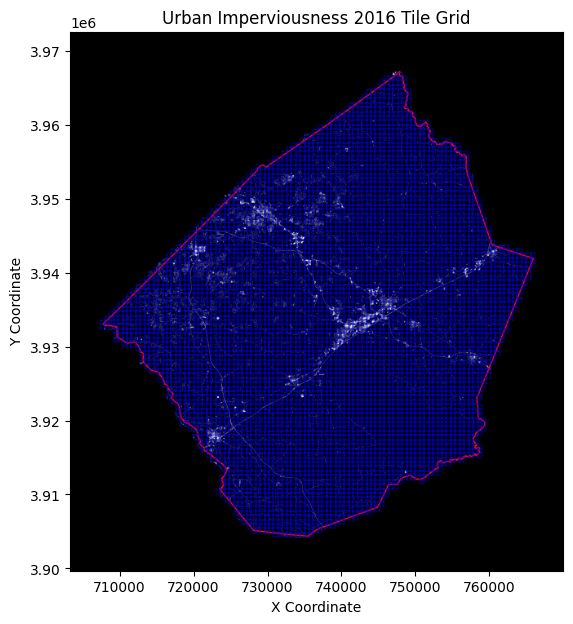

In [5]:
# Paths and variables
mosaic_path = os.path.join("../data", "urban_imperviousness.tif")

# CRS to match (assuming both county_boundary and tiles_gdf have the same CRS)
target_crs = county_boundary.crs

if not os.path.exists(mosaic_path):
    # Get the list of urban imperviousness tile paths
    tile_paths = tiles_gdf['ui_tile_path'].dropna().tolist()

    # List to hold rasterio datasets
    src_files_to_mosaic = []

    # Read each tile and append to the list
    for fp in tile_paths:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

    # Merge the tiles into a mosaic
    mosaic_array, out_trans = merge(src_files_to_mosaic)

    # Close the individual datasets
    for src in src_files_to_mosaic:
        src.close()

    # Get metadata from one of the source files (they should all be the same)
    with rasterio.open(tile_paths[0]) as src0:
        out_meta = src0.meta.copy()

    # Update the metadata to reflect the mosaic dimensions and transform
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic_array.shape[1],
        "width": mosaic_array.shape[2],
        "transform": out_trans,
        "crs": src0.crs  # This is the original CRS of the mosaic
    })

    # Reproject the mosaic array to the target CRS (county_boundary and tiles_gdf CRS)
    dst_array, dst_transform = rasterio.warp.reproject(
        source=mosaic_array,
        src_crs=out_meta['crs'],
        src_transform=out_trans,
        dst_crs=target_crs,  # Target CRS from county_boundary and tiles_gdf
        dst_transform=None,  # Let rasterio calculate the new transform
        resampling=rasterio.enums.Resampling.bilinear  # Choose appropriate resampling method
    )

    # Update metadata to reflect the new dimensions and CRS after reprojection
    out_meta.update({
        "height": dst_array.shape[1],
        "width": dst_array.shape[2],
        "transform": dst_transform,
        "crs": target_crs
    })

    # Save the reprojected mosaic to a file
    with rasterio.open(mosaic_path, "w", **out_meta) as dest:
        dest.write(dst_array)
    
    # Open the saved reprojected mosaic
    mosaic = rasterio.open(mosaic_path)
else:
    # Open the mosaic from file
    mosaic = rasterio.open(mosaic_path)

# Read the data from the mosaic
data = mosaic.read(1)  # Read the first band

# Plot the mosaic
fig, ax = plt.subplots(figsize=(7, 7))

# Use mosaic.transform for the transform parameter
rasterio.plot.show(data, transform=mosaic.transform, ax=ax, cmap='gray')

# Plot the county boundary and tile boundaries
county_boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)
tiles_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=0.35)

plt.title('Urban Imperviousness 2016 Tile Grid')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


In [6]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)
query = {"eo:cloud_cover": {"lt": 1}}

collections=["sentinel-2-l2a"]

# Dates to query
start = "2016-01-01"
end = "2024-08-31"

# Bands to query:
#  B02 (Blue) - 490 nm (10 m resolution)
#      Useful for water body delineation and identifying vegetation.
#  B03 (Green) - 560 nm (10 m resolution)
#      Useful for vegetation monitoring.
#  B04 (Red) - 665 nm (10 m resolution)
#      Useful for vegetation and crop health monitoring (e.g., chlorophyll absorption).
#  B08 (Near Infrared - NIR) - 842 nm (10 m resolution)
#      Key band for calculating NDVI and monitoring vegetation health.
bands = ["B02", "B03", "B04", "B08"]
bands_map = {"B02": "blue", "B03": "green", "B04": "red", "B08": "nir"}

# GSD (in meters)
gsd = 10

epsg = 32617

# Function to query STAC items for a tile
def query_stac_tile(tile_geometry, catalog, start, end, 
                    query, collections=["sentinel-2-l2a"], 
                    limit=1000):
    # Get the bounds of the tile in WGS84
    tile_wgs84 = gpd.GeoSeries([tile_geometry], crs="EPSG:32617").to_crs("EPSG:4326").iloc[0]
    minx, miny, maxx, maxy = tile_wgs84.bounds
    bbox = [minx, miny, maxx, maxy]

    # Perform the search
    search = catalog.search(
        collections=collections,
        bbox=bbox,
        datetime=f"{start}/{end}",
        limit=limit,
        query=query
    )
    # Get the items from the search results
    items = list(search.item_collection())
    return items

def get_subregion(dataset, bounds):
    min_x, min_y, max_x, max_y = bounds
    # Subset the dataset using xarray's sel function
    subregion = dataset.sel(
        x=slice(min_x, max_x),  # X-coordinate bounds
        y=slice(max_y, min_y)   # Y-coordinate bounds (flip due to coordinate system)
    )
    return subregion

# Function to get images from item
def get_images_from_item(item, bands, output_file_path, chunk_size=2048, dtype=np.float32, 
                        crs="EPSG:32617", bounds=None):
    # Check if the file already exists
    if not os.path.exists(output_file_path):
        print(f"Processing item: {item.id}, Date: {item.datetime}")

        band_datasets = []
        # Loop through bands and collect data
        for band in bands:
            print(f"Getting data for band: {band}")
            # Sign the asset URLs
            asset_href = planetary_computer.sign(item.assets[band].href)
            print(f"URL: {asset_href}")
            # Open the image using rioxarray
            with rasterio.Env():
                ds = rioxarray.open_rasterio(
                    asset_href,
                    chunks={"band": -1, "x": chunk_size, "y": chunk_size},
                    lock=False
                ).astype(dtype)
                if ds.rio.crs != crs:
                    ds = ds.rio.reproject(crs)
                if bounds is not None:
                    ds = get_subregion(ds, bounds)
                band_datasets.append(ds)

        # Stack bands into a single dataset
        stacked_ds = xr.concat(band_datasets, dim='band')

        # Store time as an attribute
        naive_datetime = item.datetime.replace(tzinfo=None)
        time_value = np.datetime64(naive_datetime, 'ns')
        stacked_ds.attrs['time'] = str(time_value)
        
        # Save the stacked dataset to a single GeoTIFF file
        stacked_ds.rio.to_raster(output_file_path)
        print(f"Saved multi-band data to {output_file_path}")
    else:
        print(f"Data already exists at {output_file_path}")
    return output_file_path

# Function to clean up bounds for filename
def clean_bounds(bounds):
    minx, miny, maxx, maxy = bounds
    # Round to 3 decimal places and remove any special characters
    minx_str = f"{minx:.3f}".replace('.', '_')
    miny_str = f"{miny:.3f}".replace('.', '_')
    maxx_str = f"{maxx:.3f}".replace('.', '_')
    maxy_str = f"{maxy:.3f}".replace('.', '_')
    # Combine into a single string
    bounds_str = f"{minx_str}_{miny_str}_{maxx_str}_{maxy_str}"
    return bounds_str

# Now process the tiles
for idx, tile in tiles_gdf[~tiles_gdf['processed']].iterrows():
    try:
        print(f"Processing tile {idx + 1}/{len(tiles_gdf)}")
        tile_geometry = tile['geometry']
        # Query STAC items for the tile
        tile_items = query_stac_tile(tile_geometry, catalog, start, end, 
                        query, collections=collections)
        if tile_items:
            # Collect unique items per date
            unique_items = {}
            for item in tile_items:
                date_str = item.datetime.date().isoformat()
                if date_str not in unique_items:
                    unique_items[date_str] = item
            # Process each unique item
            tile_data_files = []
            tile_bounds = tile_geometry.bounds
            # Clean up the bounds to be suitable for filename
            bounds_str = clean_bounds(tile_bounds)
            for date_str, item in unique_items.items():
                # Define the output file path
                band_sfx = "_".join(bands)
                output_file = os.path.join(tiles_data_dir, 
                                           f"tile_{idx}_{bounds_str}_{date_str}_{band_sfx}.tif")
                if not os.path.exists(output_file):
                # Download and save the data
                    try:
                        # Download and save the data
                        get_images_from_item(item, bands, output_file, 
                                             chunk_size=2048, bounds=tile_bounds)
    
                        tile_data_files.append(output_file)
                        # Update data file list in GDF
                        tiles_gdf.at[idx, 'data_files'] = tile_data_files
                        print(f"Saved data to {output_file}")
                    except Exception as e:
                        print(f"Error processing item {item.id}: {e}")
                        continue  # Skip this item and move on to the next
                else:
                    tile_data_files.append(output_file)
                    # Update data file list in GDF
                    tiles_gdf.at[idx, 'data_files'] = tile_data_files
                    print(f"Data file {output_file} already exists, skipping download")
                
            # Set 'processed' to True
            tiles_gdf.at[idx, 'processed'] = True
        else:
            # No items found for this tile
            print(f"No items found for tile {idx}")
    except Exception as e:
        # Print error message but skip marking as processed
        print(f"Error processing tile {idx}: {e}")
        continue  # Skip this tile and move on to the next one

    # Save the updated tiles_gdf to 'tiles.geojson'
    tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')

Processing tile 1/5954
Data file ../data/tiles_gdb\tile_0_707400_000_3932400_000_708000_000_3933000_000_2024-08-27_B02_B03_B04_B08.tif already exists, skipping download
Data file ../data/tiles_gdb\tile_0_707400_000_3932400_000_708000_000_3933000_000_2024-08-25_B02_B03_B04_B08.tif already exists, skipping download
Data file ../data/tiles_gdb\tile_0_707400_000_3932400_000_708000_000_3933000_000_2024-06-11_B02_B03_B04_B08.tif already exists, skipping download
Data file ../data/tiles_gdb\tile_0_707400_000_3932400_000_708000_000_3933000_000_2024-06-08_B02_B03_B04_B08.tif already exists, skipping download
Data file ../data/tiles_gdb\tile_0_707400_000_3932400_000_708000_000_3933000_000_2024-04-29_B02_B03_B04_B08.tif already exists, skipping download
Data file ../data/tiles_gdb\tile_0_707400_000_3932400_000_708000_000_3933000_000_2024-04-14_B02_B03_B04_B08.tif already exists, skipping download
Data file ../data/tiles_gdb\tile_0_707400_000_3932400_000_708000_000_3933000_000_2024-04-07_B02_B03_B

In [16]:
ds = rioxarray.open_rasterio(tiles_gdf.at[0, 'data_files'][0])
ds

<xarray.DataArray (band: 4, y: 60, x: 60)> Size: 58kB
[14400 values with dtype=float32]
Coordinates:
  * band         (band) int32 16B 1 2 3 4
  * x            (x) float64 480B 7.074e+05 7.074e+05 ... 7.08e+05 7.08e+05
  * y            (y) float64 480B 3.933e+06 3.933e+06 ... 3.932e+06 3.932e+06
    spatial_ref  int32 4B 0
Attributes:
    time:           2024-08-27T15:49:31.024000000
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0

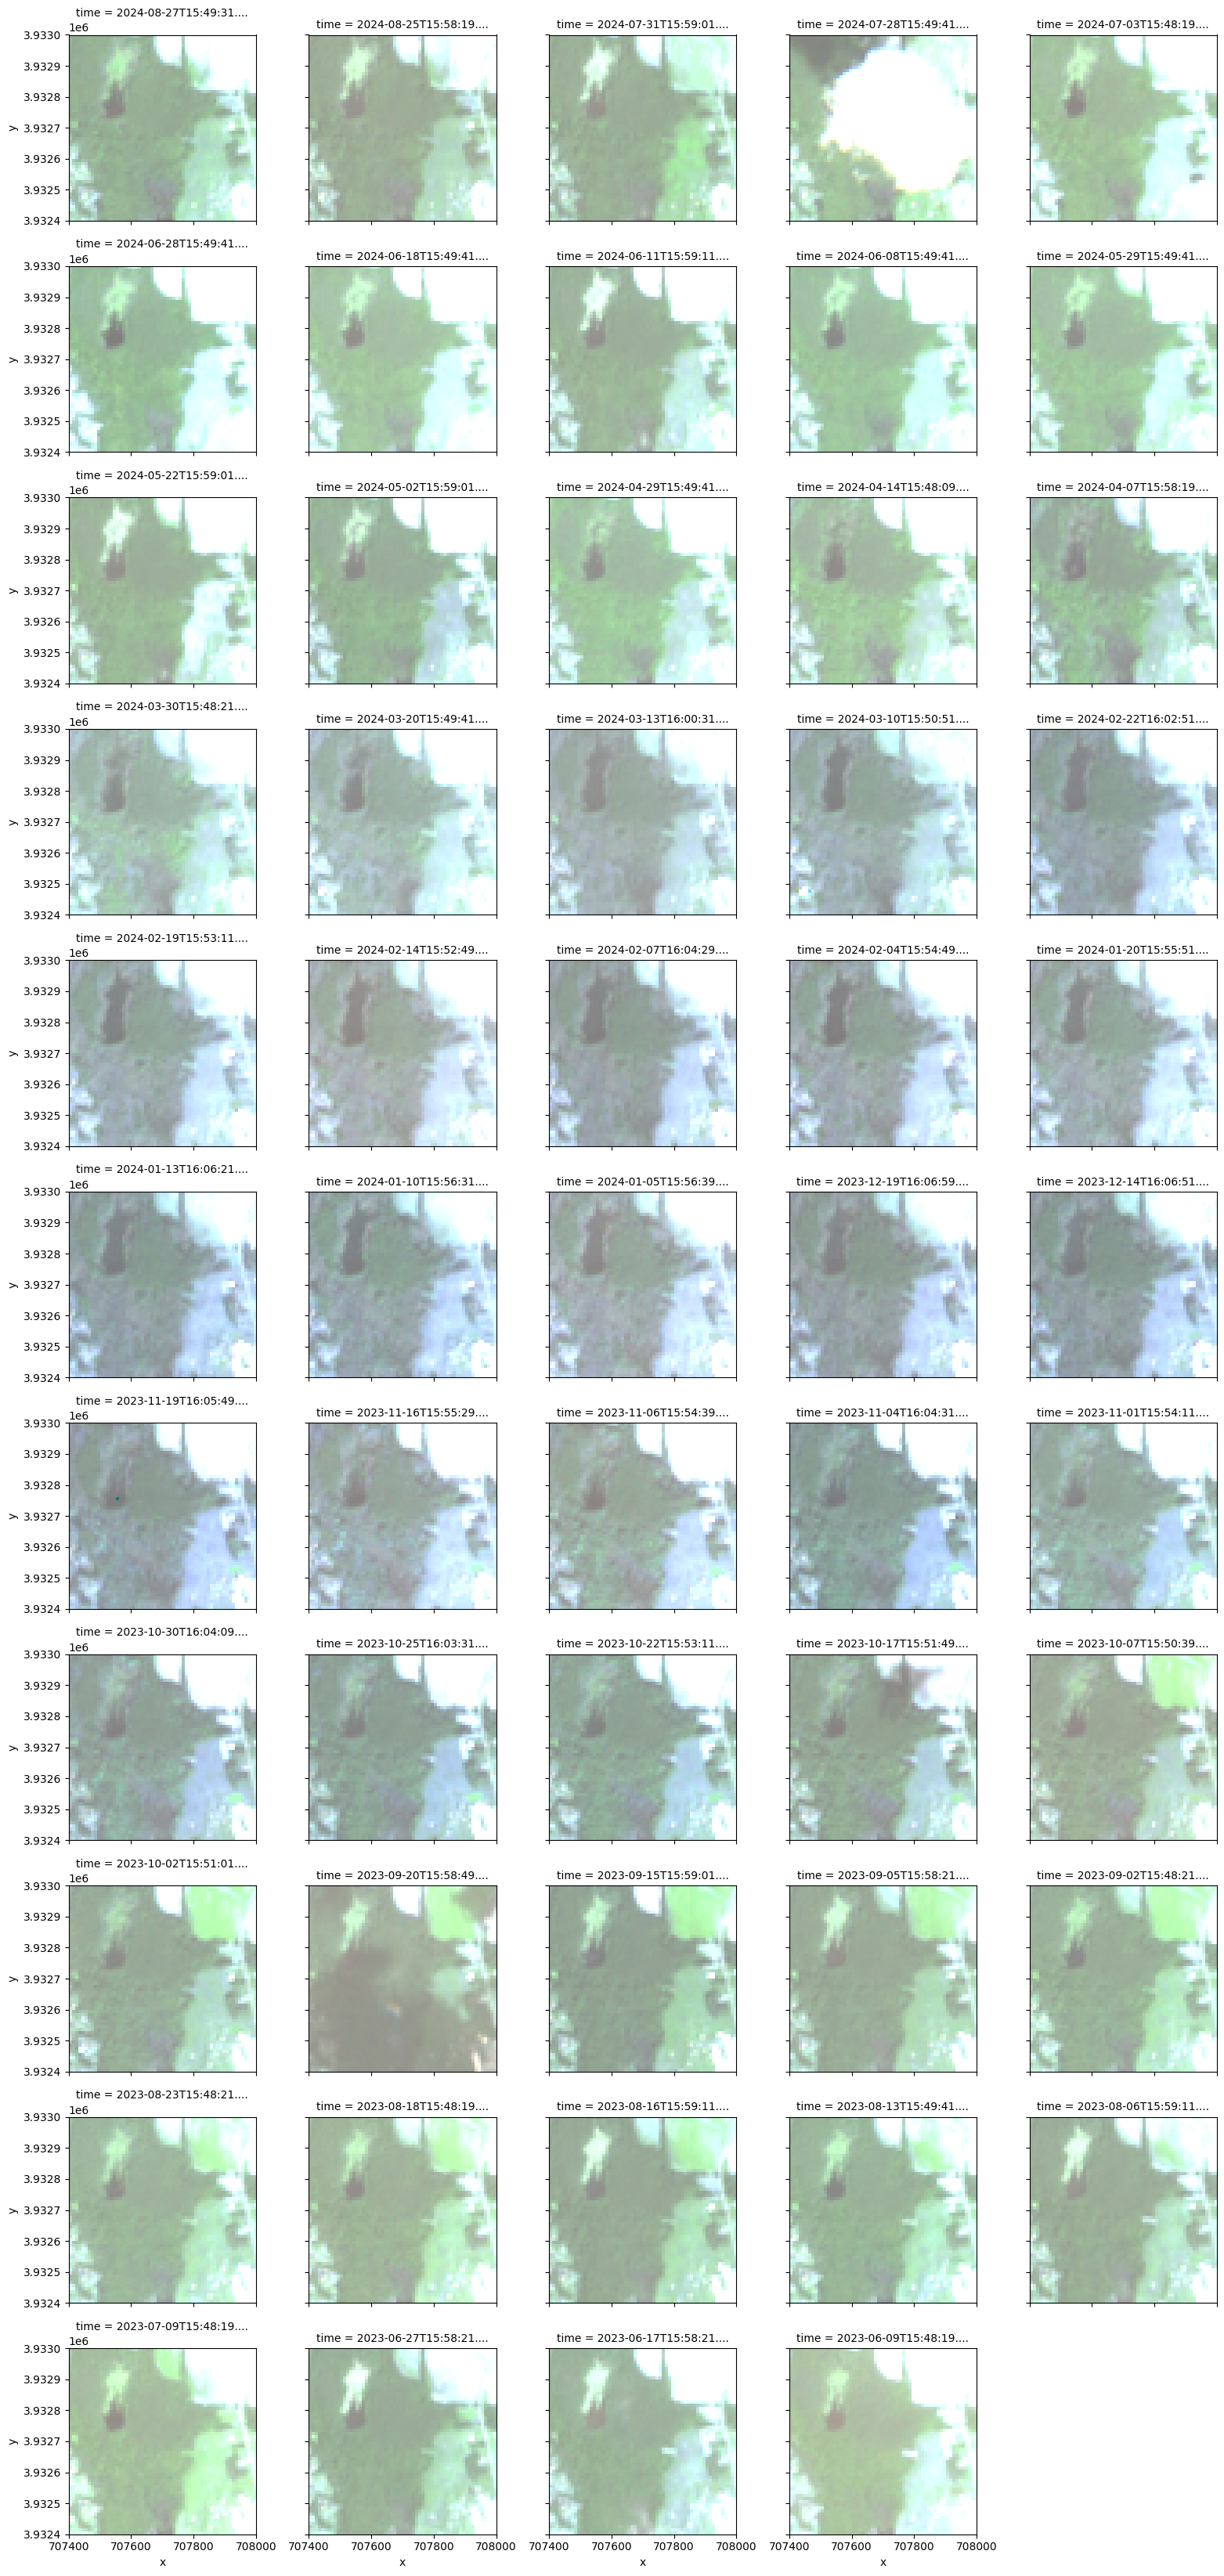

In [17]:
def get_by_idx(tile_idx, tiles_gdf, bands):
    tile_data_files = tiles_gdf.at[tile_idx, 'data_files']
    datasets = []
    for data_file in tile_data_files:
        # print(data_file)
        date_str = os.path.splitext(os.path.basename(data_file))[0].split('_')[-1]
        ds = rioxarray.open_rasterio(data_file)
        date_str = ds.time
        date = np.datetime64(date_str, 'ns')
        ds = ds.assign_coords(band=bands)
        ds = ds.expand_dims({'time': [date]})
        datasets.append(ds)
    stacked_ds = xr.concat(datasets, dim='time')
    return stacked_ds

stack = get_by_idx(0, tiles_gdf, bands)

stack.sel(band=["B02", "B03", "B04"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=5
)

In [18]:
stack

<xarray.DataArray (time: 54, band: 4, y: 60, x: 60)> Size: 3MB
array([[[[1144., 1142., 1139., ..., 3048., 3012., 3036.],
         [1223., 1165., 1138., ..., 2896., 2960., 3072.],
         [1223., 1126., 1142., ..., 2858., 2910., 2484.],
         ...,
         [1332., 1430., 1390., ..., 3020., 3294., 3070.],
         [1407., 1442., 1414., ..., 3434., 3392., 2968.],
         [1454., 1496., 1431., ..., 3314., 2998., 3152.]],

        [[1385., 1358., 1346., ..., 3566., 3596., 3652.],
         [1398., 1346., 1334., ..., 3402., 3456., 3652.],
         [1391., 1335., 1347., ..., 3364., 3416., 3126.],
         ...,
         [1659., 1770., 1701., ..., 3128., 3376., 3362.],
         [1696., 1714., 1750., ..., 3828., 3908., 3618.],
         [1782., 1822., 1731., ..., 3754., 3316., 3386.]],

        [[1186., 1144., 1147., ..., 4120., 4200., 4340.],
         [1258., 1165., 1136., ..., 4066., 4038., 4320.],
         [1248., 1159., 1156., ..., 3972., 3940., 3390.],
         ...,
...
         ...,
         [1832., 1962., 1946., ..., 3496., 3900., 3454.],
         [1846., 1986., 2080., ..., 3668., 3828., 3552.],
         [2048., 2156., 2138., ..., 3366., 3142., 3154.]],

        [[1385., 1306., 1298., ..., 4124., 4228., 4532.],
         [1566., 1345., 1297., ..., 4066., 4086., 4412.],
         [1484., 1280., 1292., ..., 4032., 4356., 3918.],
         ...,
         [1665., 1848., 1828., ..., 3720., 4140., 3930.],
         [1776., 1954., 1946., ..., 4046., 4156., 3990.],
         [1900., 2166., 2110., ..., 3788., 3456., 3376.]],

        [[5620., 5596., 5148., ..., 5260., 5332., 5596.],
         [5360., 5300., 4844., ..., 5084., 5196., 5504.],
         [5504., 5356., 4948., ..., 5068., 5312., 5408.],
         ...,
         [5108., 4752., 4604., ..., 4074., 4328., 4488.],
         [4892., 4652., 4688., ..., 4656., 4584., 4596.],
         [4712., 4784., 4716., ..., 4664., 4196., 4056.]]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 432B 2024-08-27T15:49:31.024000 ... 20...
  * x            (x) float64 480B 7.074e+05 7.074e+05 ... 7.08e+05 7.08e+05
  * y            (y) float64 480B 3.933e+06 3.933e+06 ... 3.932e+06 3.932e+06
    spatial_ref  int32 4B 0
  * band         (band) <U3 48B 'B02' 'B03' 'B04' 'B08'
Attributes:
    time:           2024-08-27T15:49:31.024000000
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0

In [19]:
def get_stack_centroid_lat_lon(stack):
    # Extract the x and y coordinates
    x_coords = stack['x'].values
    y_coords = stack['y'].values
    # Compute the centroid in the dataset's CRS
    x_min = x_coords.min()
    x_max = x_coords.max()
    y_min = y_coords.min()
    y_max = y_coords.max()
    x_centroid = (x_min + x_max) / 2
    y_centroid = (y_min + y_max) / 2
    # Create a GeoDataFrame with the centroid point
    centroid_point = Point(x_centroid, y_centroid)
    gdf = gpd.GeoDataFrame(geometry=[centroid_point], crs=stack.rio.crs)
    # Reproject to WGS84 (EPSG:4326)
    gdf_wgs84 = gdf.to_crs('EPSG:4326')
    # Extract latitude and longitude
    lon = gdf_wgs84.geometry.x.values[0]
    lat = gdf_wgs84.geometry.y.values[0]
    return lat, lon

# Use the function on your stack
lat, lon = get_stack_centroid_lat_lon(stack)
print(f'Centroid Latitude: {lat}, Longitude: {lon}')

Centroid Latitude: 35.51617684432586, Longitude: -78.70959949327006


In [23]:
# `git clone https://github.com/Clay-foundation/model.git`
# Download clay-v1-base.ckpt from https://huggingface.co/made-with-clay/Clay/tree/main

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "../clay-ckpt/clay-v1-base.ckpt"
metadata_path = "../model/configs/metadata.yaml" 
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path=metadata_path, shuffle=False, mask_ratio=0
)

model.eval()
model = model.to(device)

c:\Users\bento\gis582\project\env\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [34]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
metadata = Box(yaml.safe_load(open(metadata_path)))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in stack.band.values:
    mean.append(metadata[platform].bands.mean[bands_map[str(band)]])
    std.append(metadata[platform].bands.std[bands_map[str(band)]])
    waves.append(metadata[platform].bands.wavelength[bands_map[str(band)]])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

blue
green
red
nir


In [35]:
# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


datetimes = stack.time.values.astype("datetime64[s]").tolist()
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]

# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
pixels = torch.from_numpy(stack.data.astype(np.float32))
pixels = transform(pixels)

In [36]:
# Prepare additional information
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), 
        dtype=torch.float32, device=device
    ),
    "pixels": pixels.to(device),
    "gsd": torch.tensor(0.6, device=device),
    "waves": torch.tensor(waves, device=device),
}

In [37]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

Patches shape: torch.Size([54, 49, 768])
Grid size: 7


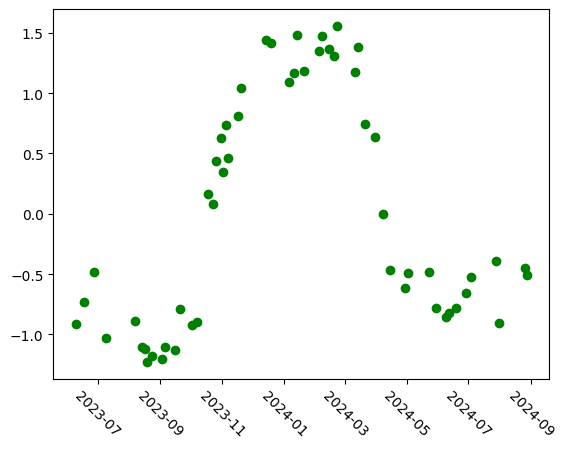

In [38]:
# Run PCA
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings)

plt.xticks(rotation=-45)

plt.scatter(stack.time, pca_result, color="green")
